## **Agricultural drought in central South America**

In [3]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

from xclim.indices.stats import fit

## **ERA5**

In [3]:
pr = decode_times(xr.open_dataset("data/era5_tp_-80--40E_-50--10N_su.nc", decode_times = False)).tp
evap = decode_times(xr.open_dataset("data/era5_evap_-80--40E_-50--10N_su.nc", decode_times = False)).evap
eff_pr = pr - evap

lsm = xr.open_dataset("../../Data/era5/era5_lsm_025.nc").squeeze(drop = True).lsm.rename(longitude = "lon", latitude = "lat").sel(lon = pr.lon, lat = pr.lat)

evap, pr, eff_pr = [da.where(lsm >= 0.5) for da in [evap, pr, eff_pr]]

### **SPI_3**

In [105]:
pr_n = pr.rolling(time = 3, center = False).mean(keep_attrs = False)
spi_monthly = []

# fit each calendar month in turn
for i in range(12):
    
    # select current calendar month
    pr_m = pr_n.sel(time = pr_n.time.dt.month == i+1)
    
    # estimate parameters over calibration period
    pr_cal = pr_m.sel(time = slice("1961", "2010")).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
    
    # normalise all values using fitted parameters
    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                           input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
    
    spi_monthly.append(spi_m)

# concatenate monthly fitted values, reorder & relabel
spi = xr.concat(spi_monthly, "time").sortby("time").rename("spi").assign_attrs(long_name = "SPI_3", notes = "Calibrated against 1970-2010")

# save to netcdf
spi.to_netcdf("era5_spi3.nc")

#### **Maps of results**

In [21]:
spi = xr.open_dataset("era5_spi3.nc").spi

In [32]:
spi.time

<xarray.DataArray 'time' (time: 876)>
array(['1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01

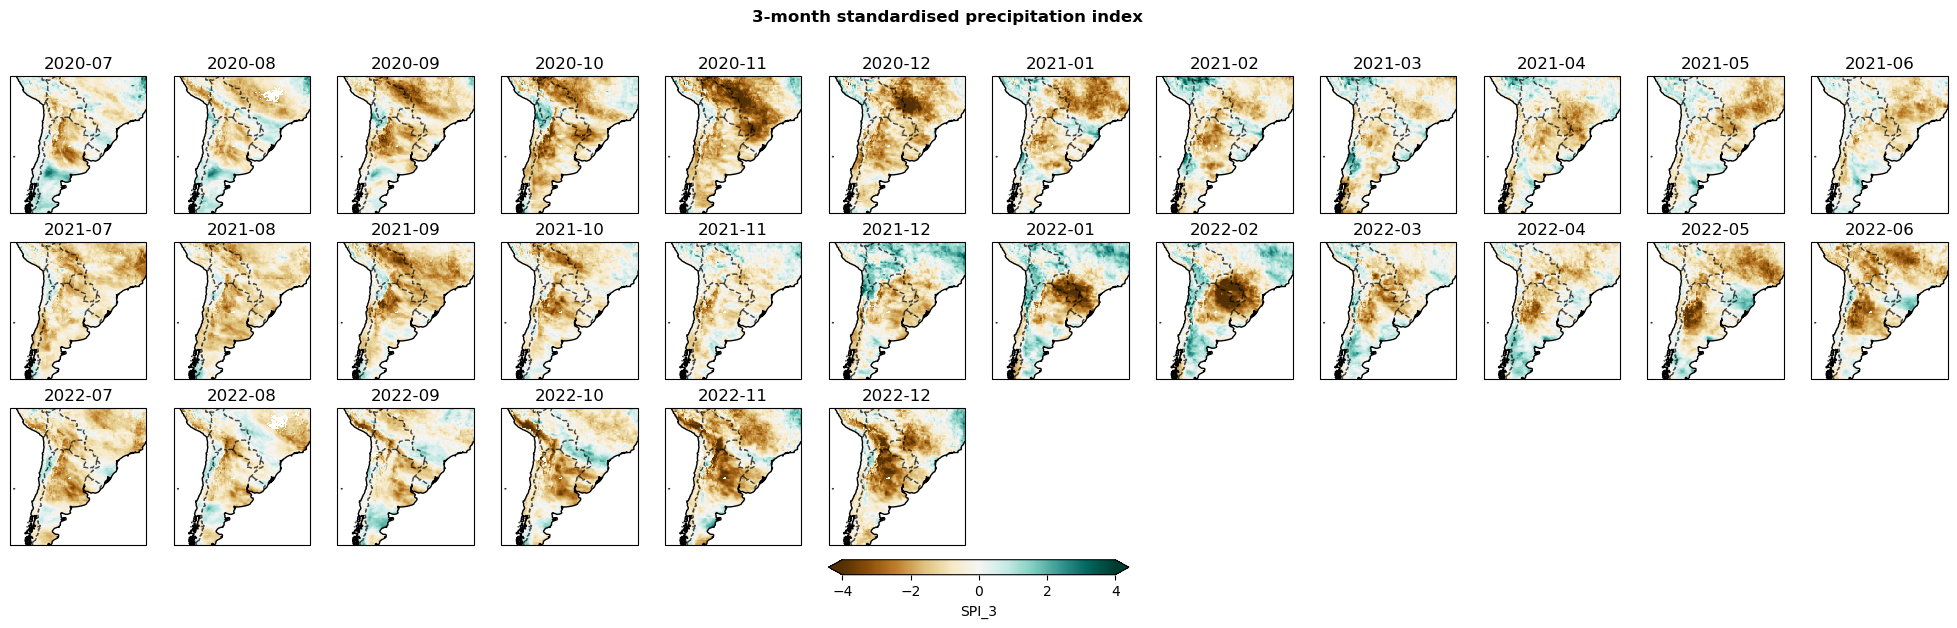

In [68]:
fig, axs = plt.subplots(ncols = 12, nrows = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,6.5))

for ax in fig.axes[30:]: ax.set_axis_off()

for i in range(30):
    
    ax = fig.axes[i]
    cbar = spi.isel(time = 876-(30-i)).plot(ax = ax, add_colorbar = False, cmap = "BrBG", vmin = -4, vmax = 4)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
    ax.set_title(spi.time[876-(30-i)].dt.strftime("%Y-%m").values)
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPI_3", extend = "both")
plt.suptitle("3-month standardised precipitation index", fontweight = "bold")

plt.savefig("era5_spi3_maps.png")

In [11]:
# fit each calendar month in turn
for i in range(12):
    
    pr_m = pr3.sel(time = pr3.time.dt.month == i+1)
    
    # estimate parameters over calibration period
    pr_cal = pr_m.sel(time = slice("1960-07-01", "2010-06-30")).copy()
    pars = fit(pr_cal.dropna("time", "any"), dist = "gamma", method = "PWM")
    
    # if fitting evaluation values, only required for evaluation period
    if "eval" in varnm:
        pr6_m = pr6_m.sel(time = slice(cal_period[:8], cal_period[9:]))
        
    # normalise all values using fitted parameters
    spi6_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr6_m, pars, 
                            input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr6_m.time)
    
    # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
    spi6_finite = xr.concat([spi6_m.where(~np.isinf(spi6_m)), 
                             xr.ones_like(spi6_m).where(spi6_m == np.inf) * spi6_m.where(spi6_m < np.inf).max("time"),
                             xr.ones_like(spi6_m).where(spi6_m == -np.inf) * spi6_m.where(spi6_m > -np.inf).min("time")], "new").sum("new").copy()
    
    # add to output list
    spi6.append(spi6_finite)
    
    # concatenate monthly fitted values, reorder & relabel
    xr.concat(spi6, "time").sortby("time").rename("spi6").to_netcdf(re.sub("prcptot", varnm, fnm))
    print(".", end = "")

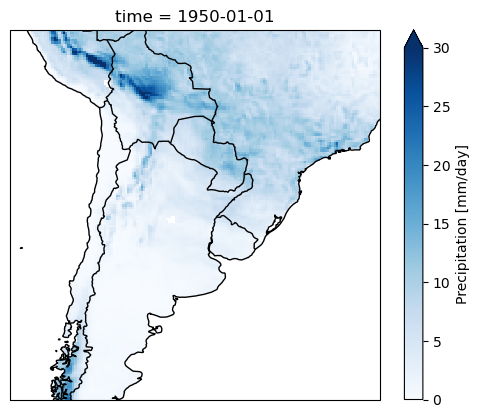

In [22]:
pr.isel(time = 0).plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "Blues", vmax = 30)
ax = plt.gcf().axes[0]

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)